In [3]:
import ThinFilmDataCreation as tfdc
import matplotlib.pyplot as plt
import numpy as np

In [58]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import dask
import glob as glob
from tifffile import imread, imshow
import warnings
import dask

def attempt(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q

def attempt2(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q, fit_compos, NMF_data


def Run_NMF(Real_Data, init= None, solver = 'cd', beta_loss = 'frobenius', itear = 1000, show = False):
    
    """" Comparison of multiple components without manually comparing
    multiple components all at once. There are a few ways that this can be done. One way
    is to take the residuals of the datasets with themselves to see which is the closests to the 
    "correct" component. This may only be done on sample data potentially. Could include a 
    simulated dataset of what the standing component should look like give or take some 
    variations in the data. When the residuals are taken if it is less than some given 
    percentage the would be the dataset/NMF component to use further. There may be multiple
    thus having to go in manually to find differences. 
    
    To do this, will need to import the simulated XRD pattern from VESTA and then take the residual differences
    of each component and compared to the simulated pattern. Will have the program spit out the compnents that
    meet the cutoff. """

    In = init
    Solve = solver
    Beta = beta_loss
    It = itear
    

    jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1, Real_Data.shape[1])]
    #jobs = [dask.delayed(attempt)(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It) for i in range(1,20)]
    calcs = dask.compute(jobs)[0]

    calcs = np.array(calcs)
    min_Q = np.min(calcs)
    noc = np.where(calcs == min_Q)
    noc_2 = noc[0]
    number_of_components = noc_2[0] +1

    Divergence, compos, NMF_Data_2 = attempt2(Real_Data, Real_Data.shape[1], number_of_components, In, Solve, Beta)
            
    
    print('The beta-divergence is: ', Divergence, '%\n','The final number of components used were',number_of_components+1, '\n') 
    
    
    m = pd.DataFrame(compos)
    m = m.T
    
    if show == True:
        plt.figure(figsize = (5,5))
        colors = plt.cm.magma(np.linspace(0,1, number_of_components))
        i = 0
        while i < number_of_components:
            plt.plot(m[i], c = colors[i], alpha = 0.7)
            i = i+1
    
    return m,NMF_Data_2, min_Q

def AggCluster(Number_Clusters, data):
    
    """A program that will take in the type of scikitlearn clustering algorithm
        desired and the number of clusters as well as the data in a numpy array
        and output the associated clusters with the original data. This will make
        the 'latent' space from the clustering algorithms have more meaning"""

    from sklearn.cluster import AgglomerativeClustering
    Make_Clusters= AgglomerativeClustering(n_clusters = Number_Clusters, compute_distances=True)
    y_kmeans = Make_Clusters.fit_predict(data)
    information = Make_Clusters.fit(data)
    parameter = information.distances_

    x = 0
    Understanding_data = {"Cluster_Number":[], "Int_Angle":[]};
    while x < len(data):
        Understanding_data["Cluster_Number"].append(y_kmeans[x])
        Understanding_data["Int_Angle"].append(data[x])
        x = x+1
        
    # Create an empty list to store the data
    data_list = []
    
        
    q = 0
    while q < Number_Clusters:
        z = 0
        plt.figure(figsize=(5,5))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Agglomerative Clustering'+' ' +str(q))

        while z < len(data):
            if Understanding_data["Cluster_Number"][z] == q:
                plt.plot(Understanding_data["Int_Angle"][z], label = 'Component'+str(z))
            z = z+1
    
        # Check if the plot looks good if the plot looks good, append the data to the list
        plt.show(block = False)
        plt.pause(0.1)
        
        if input("Do the identified components look like an isotropic scattering signal? (y/n)") == 'y':
            i = 0
            while i < len(data):
                if Understanding_data["Cluster_Number"][i] == q:
                    data_list.append(Understanding_data["Int_Angle"][i])
                i = i+1
                
        q = q+1
    
    return Understanding_data, data_list


def smooth_components(Identified_components, filter_strength = 2, show = False):
    '''A function that will smooth the components identified from the agglomerative clustering algorithm'''
    
    # Importing required library
    from scipy.signal import savgol_filter
    
    # Defining a dictionary that maps filter strength to the number of points for the smoothing window
    strength_to_points = {1: 3, 2: 5, 3: 7, 4: 11, 5: 15}
    
    # Retrieving the number of points for the smoothing window based on the filter strength provided
    points = strength_to_points.get(filter_strength)

    # Applying Savitzky-Golay filter to smooth the identified components by taking their average along the columns
    smoothed_compos = savgol_filter(np.mean(Identified_components, axis = 0), points, 1)
    
    # If show argument is True, plotting the original components, their average, and the smoothed components
    if show == True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
        ax1.plot(Identified_components.T, c = 'k', linewidth = 2, alpha = 0.7)
        ax1.set_title('Identified Components')
        ax1.set_ylabel('Intensity')
        ax2.plot(np.mean(Identified_components, axis = 0), c = 'r', linewidth = 2, alpha = 0.7)
        ax2.set_ylabel('Intensity')
        ax2.set_title('Mean of Identified Components')
        ax3.plot(smoothed_compos, c = 'g', linewidth = 2, alpha = 0.7, label = 'Smoothed Component')
        ax3.scatter(np.arange(len(np.mean(Identified_components, axis = 0))), np.mean(Identified_components, axis = 0), c = 'r', s = 10, 
                    label = 'Mean Component')
        ax3.set_xlabel('Data Points')
        ax3.set_title('Smoothed Component')
        ax3.set_ylabel('Intensity')
        ax3.legend()
    
    # Returning the smoothed components
    return smoothed_compos

def run_nmfac(Data, initialize_iter = 0, clusters = 5):
    """A function that will run the NMF algorithm and then cluster with agglomerative clustering the components and returns the 
        identified components for later PDF analysis. The function starts with a random initializer
        that will be used to initialize the NMF algorithm. The user can decide how many iterations the 
        initializer takes. Then it will go through the NMF algorithm and compare the beta divergences of all the
        initializations and select the one with the lowest. By default, there is no initializer and the NMF algorithm
        uses preset parameters to run the algorithm. """
        
        #NMF Parameter Values
        
    import warnings
    warnings.filterwarnings("ignore")
    
    
    init_params = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
    solver_params = ['cd', 'mu']
    beta_loss_params = ['frobenius', 'kullback-leibler']
    tol_params = np.arange(0.00001, 0.01, 0.0001)
    max_iter_params = np.arange(100, 10000, 100)
    shuffle_params = [True, False]
        
    #When random initializers are not wanted
    if initialize_iter == 0:
        weights, components, beta = Run_NMF(Data, show = True)
        AggComponents = np.array(components).T
        AggClusters, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
        
    elif initialize_iter > 0:
        beta_div = []
        
        init_for_init = np.random.choice(init_params,initialize_iter)
        solver_for_init = np.random.choice(solver_params, initialize_iter)
        beta_loss_for_init = np.random.choice(beta_loss_params, initialize_iter)
        tol_for_init = np.random.choice(tol_params, initialize_iter)
        max_iter_for_init = np.random.choice(max_iter_params, initialize_iter)
        shuffle_for_init = np.random.choice(shuffle_params, initialize_iter)
        
        for i in range(initialize_iter):
            
            if beta_loss_for_init[i] == 'kullback-leibler':
                solver_for_init[i] = 'mu'
                
            print('The parameters selected for run' + str([i]) + ' are ' + str(init_for_init[i]) + ', ' + str(solver_for_init[i]) + ', ' + str(beta_loss_for_init[i]) + ', ' + str(tol_for_init[i]) + ', ' + str(max_iter_for_init[i]) + ', ' + str(shuffle_for_init[i]) + '. \n' )
            weights, components, beta = Run_NMF(Data, init = init_for_init[i], solver = solver_for_init[i], 
                                                beta_loss = beta_loss_for_init[i], itear = max_iter_for_init[i], show = False)
            
            beta_div.append(beta)
        beta_np = np.array(beta_div)
        good_init = np.argmin(beta_np)
        
        weights, components, beta = Run_NMF(Data, show = True, init = init_for_init[good_init], solver = solver_for_init[good_init], beta_loss=beta_loss_for_init[good_init],
                                             itear = max_iter_for_init[good_init])
        
        AggComponents = np.array(components).T
        AggClusters, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
            
        
    return found_compos

In [49]:
def run_nmfac(Data, initialize_iter = 0, clusters = 5):
    """A function that will run the NMF algorithm and then cluster with agglomerative clustering the components and returns the 
        identified components for later PDF analysis. The function starts with a random initializer
        that will be used to initialize the NMF algorithm. The user can decide how many iterations the 
        initializer takes. Then it will go through the NMF algorithm and compare the beta divergences of all the
        initializations and select the one with the lowest. By default, there is no initializer and the NMF algorithm
        uses preset parameters to run the algorithm. """
        
        #NMF Parameter Values
        
    import warnings
    warnings.filterwarnings("ignore")
    
    
    init_params = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
    solver_params = ['cd', 'mu']
    beta_loss_params = ['frobenius', 'kullback-leibler']
    tol_params = np.arange(0.00001, 0.01, 0.0001)
    max_iter_params = np.arange(100, 10000, 100)
    shuffle_params = [True, False]
        
    #When random initializers are not wanted
    if initialize_iter == 0:
        weights, components, beta = Run_NMF(Data, show = True)
        AggComponents = np.array(components).T
        AggClusters, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
        
    elif initialize_iter > 0:
        beta_div = []
        
        init_for_init = np.random.choice(init_params,initialize_iter)
        solver_for_init = np.random.choice(solver_params, initialize_iter)
        beta_loss_for_init = np.random.choice(beta_loss_params, initialize_iter)
        tol_for_init = np.random.choice(tol_params, initialize_iter)
        max_iter_for_init = np.random.choice(max_iter_params, initialize_iter)
        shuffle_for_init = np.random.choice(shuffle_params, initialize_iter)
        
        for i in range(initialize_iter):
            
            if beta_loss_for_init[i] == 'kullback-leibler':
                solver_for_init[i] = 'mu'
                
            print('The parameters selected for run' + str([i]) + ' are ' + str(init_for_init[i]) + ', ' + str(solver_for_init[i]) + ', ' + str(beta_loss_for_init[i]) + ', ' + str(tol_for_init[i]) + ', ' + str(max_iter_for_init[i]) + ', ' + str(shuffle_for_init[i]) + '. \n' )
            weights, components, beta = Run_NMF(Data, init = init_for_init[i], solver = solver_for_init[i], 
                                                beta_loss = beta_loss_for_init[i], itear = max_iter_for_init[i], show = False)
            
            beta_div.append(beta)
        beta_np = np.array(beta_div)
        good_init = np.argmin(beta_np)
        
        weights, components, beta = Run_NMF(Data, show = True, init = init_for_init[good_init], solver = solver_for_init[good_init], beta_loss=beta_loss_for_init[good_init],
                                             itear = max_iter_for_init[good_init])
        
        AggComponents = np.array(components).T
        AggClusters, found_compos = AggCluster(clusters, AggComponents)
        
        found_compos = np.array(found_compos)
            
        
    return found_compos

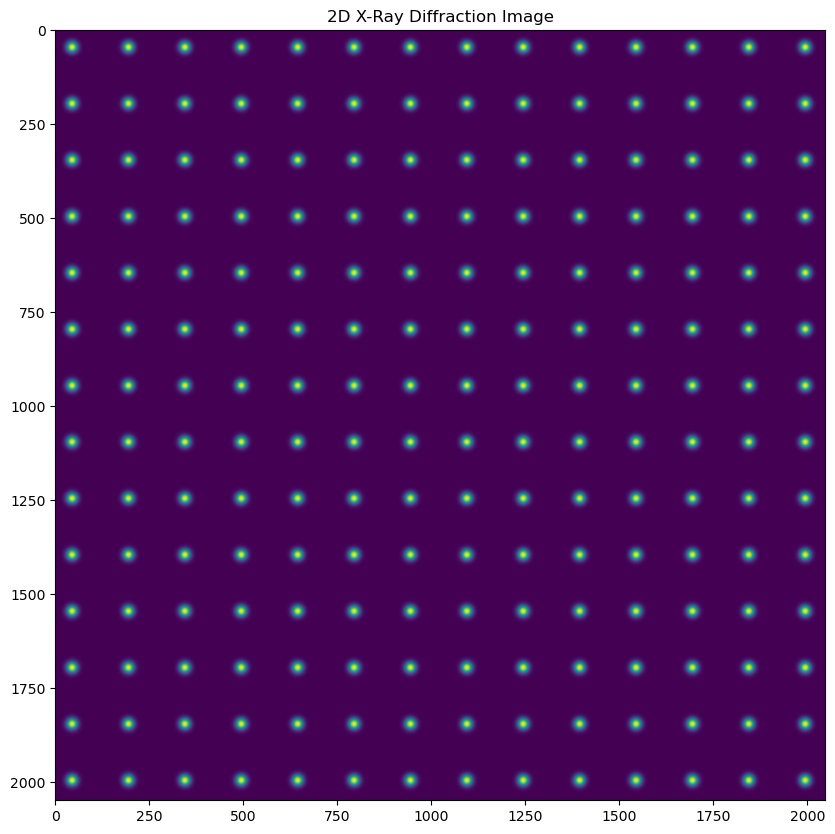

Select calibrant:
1. AgBh
2. Al
3. alpha_Al2O3
4. Au
5. C14H30O
6. CeO2
7. Cr2O3
8. cristobaltite
9. CrOx
10. CuO
11. hydrocerussite
12. LaB6
13. LaB6_SRM660a
14. LaB6_SRM660b
15. LaB6_SRM660c
16. mock
17. NaCl
18. Ni
19. PBBA
20. Pt
21. quartz
22. Si
23. Si_SRM640
24. Si_SRM640a
25. Si_SRM640b
26. Si_SRM640c
27. Si_SRM640d
28. Si_SRM640e
29. TiO2
30. ZnO
LaB6


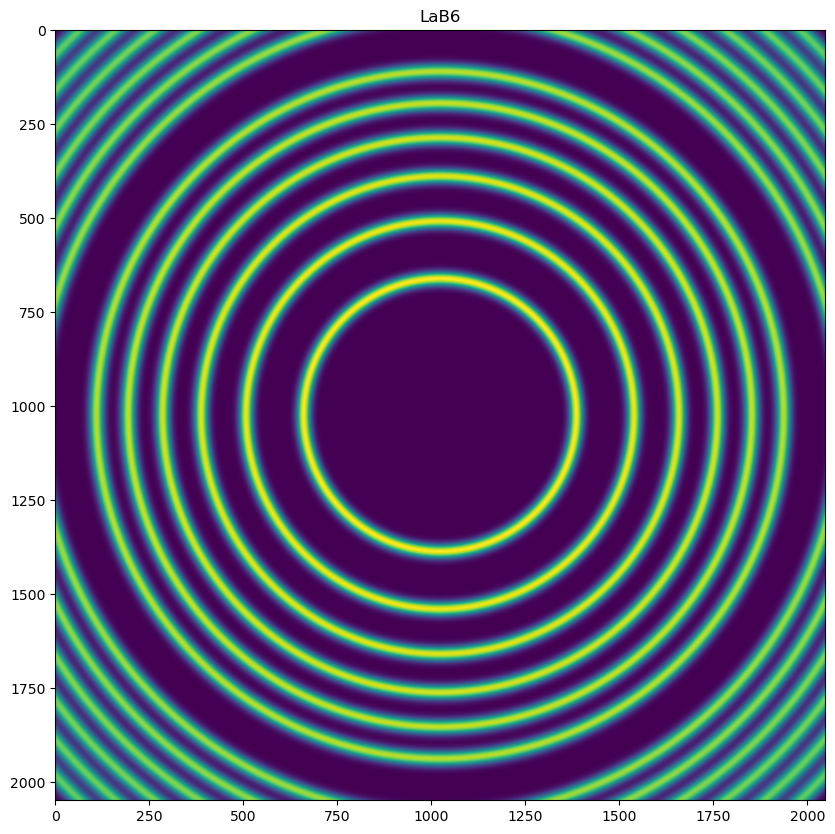

In [48]:
spots = tfdc.create_anisotropic(15, 10, 150, 90)
pattern = tfdc.create_isotropic(.6, .5e-10, cmap = 'viridis')

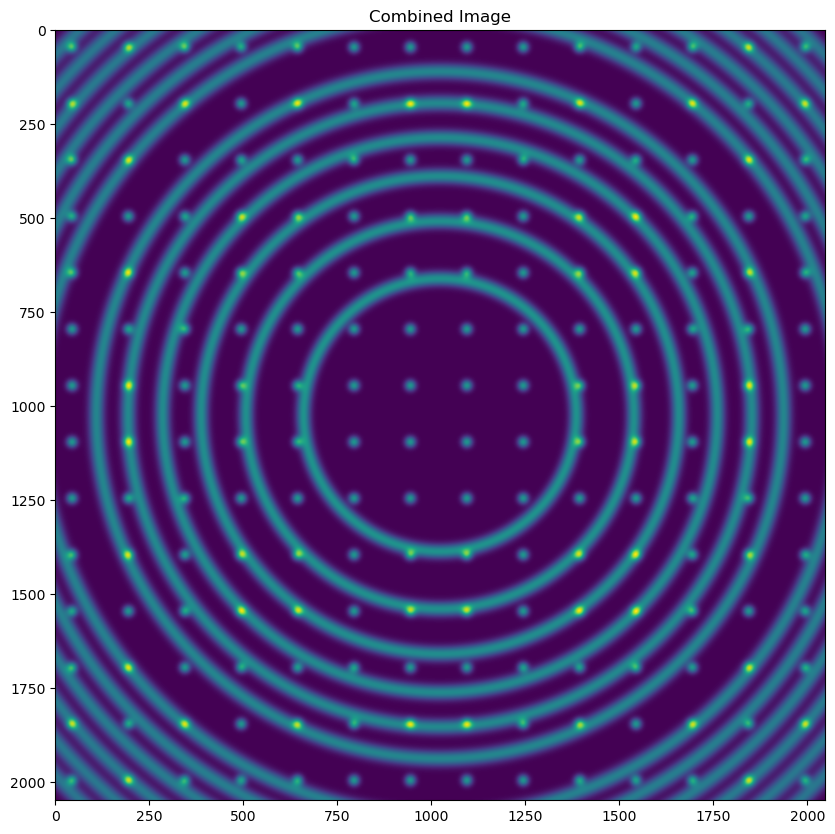

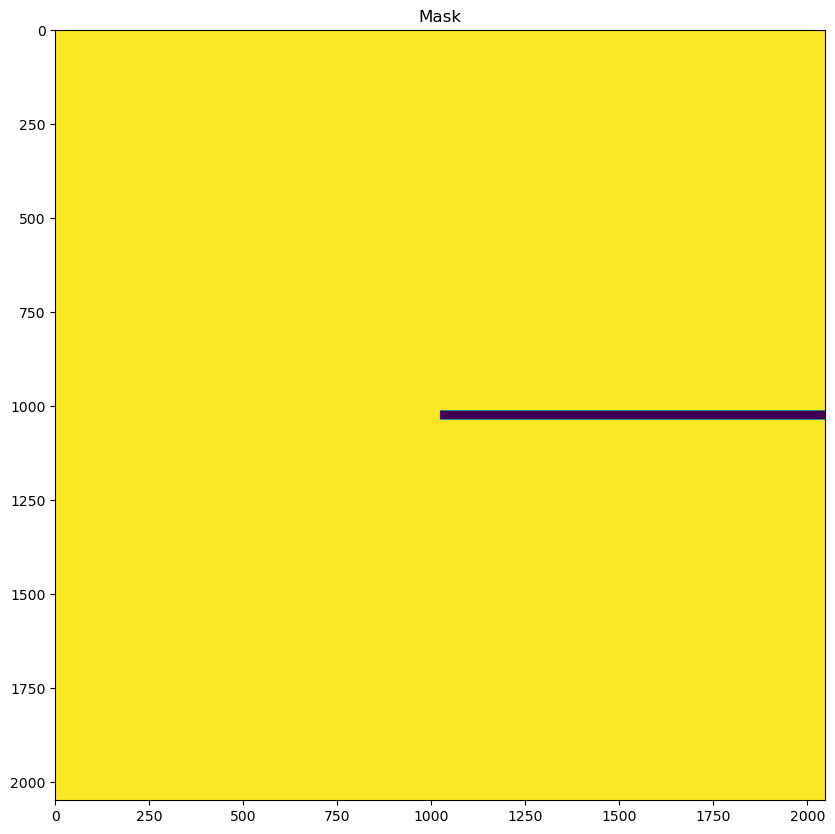

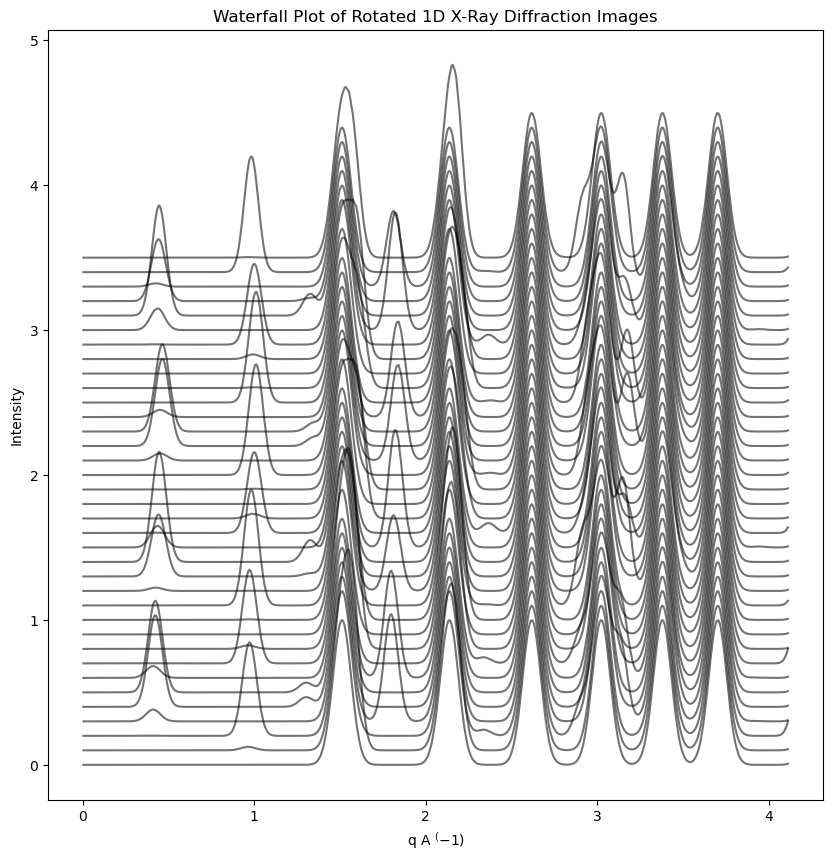

In [50]:
thin_film = tfdc.combine_image(spots, pattern)
mask = tfdc.create_mask(thin_film, 12)

q, data = tfdc.rotate_and_integrate(thin_film, 10, .6, .5e-10, resolution= 600, mask = mask)

The parameters selected for run[0] are nndsvd, cd, frobenius, 0.00791, 3700, False. 

The beta-divergence is:  1.677136934745607 %
 The final number of components used were 35 

The parameters selected for run[1] are nndsvda, mu, kullback-leibler, 0.00671, 8000, False. 

The beta-divergence is:  240.20424258434235 %
 The final number of components used were 29 

The parameters selected for run[2] are nndsvd, mu, kullback-leibler, 0.00411, 6500, False. 

The beta-divergence is:  307.8688361805035 %
 The final number of components used were 35 

The parameters selected for run[3] are random, mu, frobenius, 0.00741, 3300, True. 

The beta-divergence is:  69.976350672185 %
 The final number of components used were 36 

The parameters selected for run[4] are nndsvdar, mu, kullback-leibler, 0.00541, 9200, False. 

The beta-divergence is:  34.639832805476175 %
 The final number of components used were 29 

The parameters selected for run[5] are nndsvd, mu, kullback-leibler, 0.0003100000000000

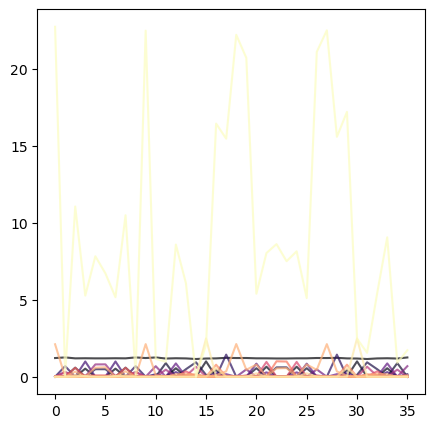

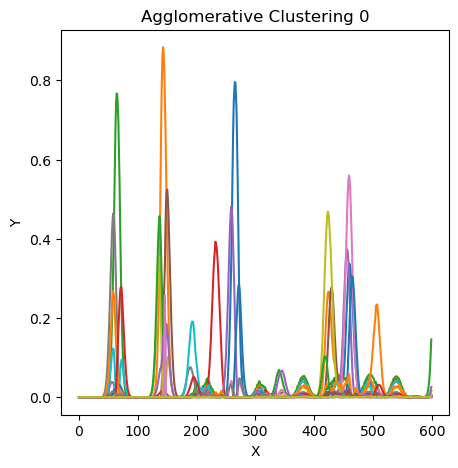

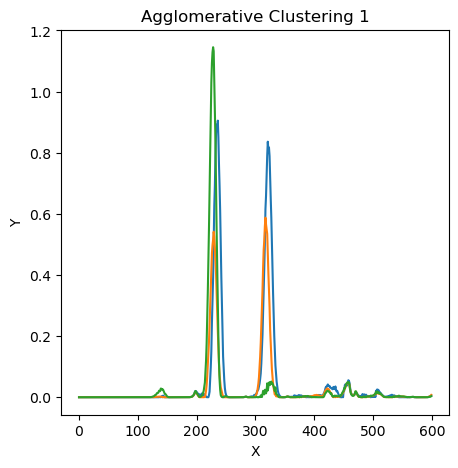

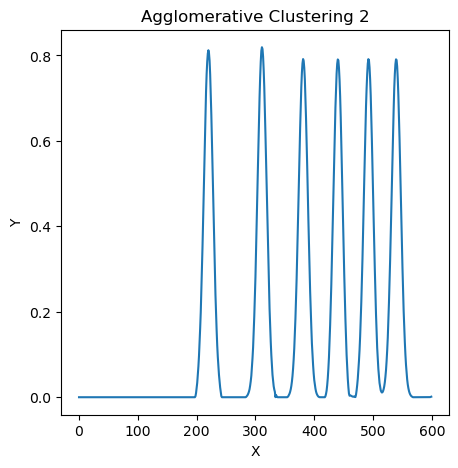

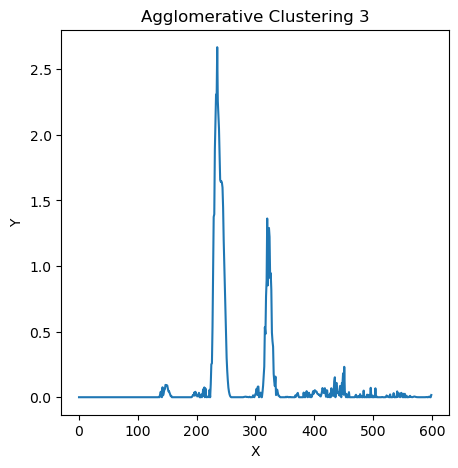

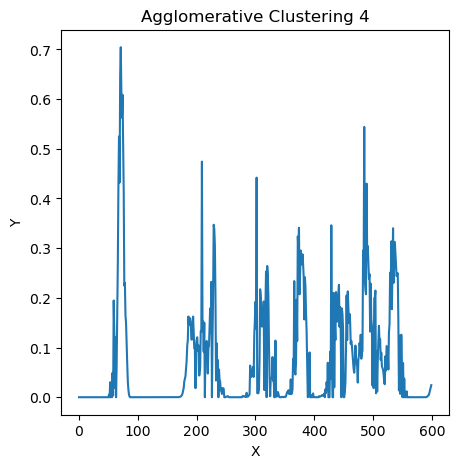

In [65]:
my_comps = run_nmfac(data, initialize_iter = 7, clusters = 5)

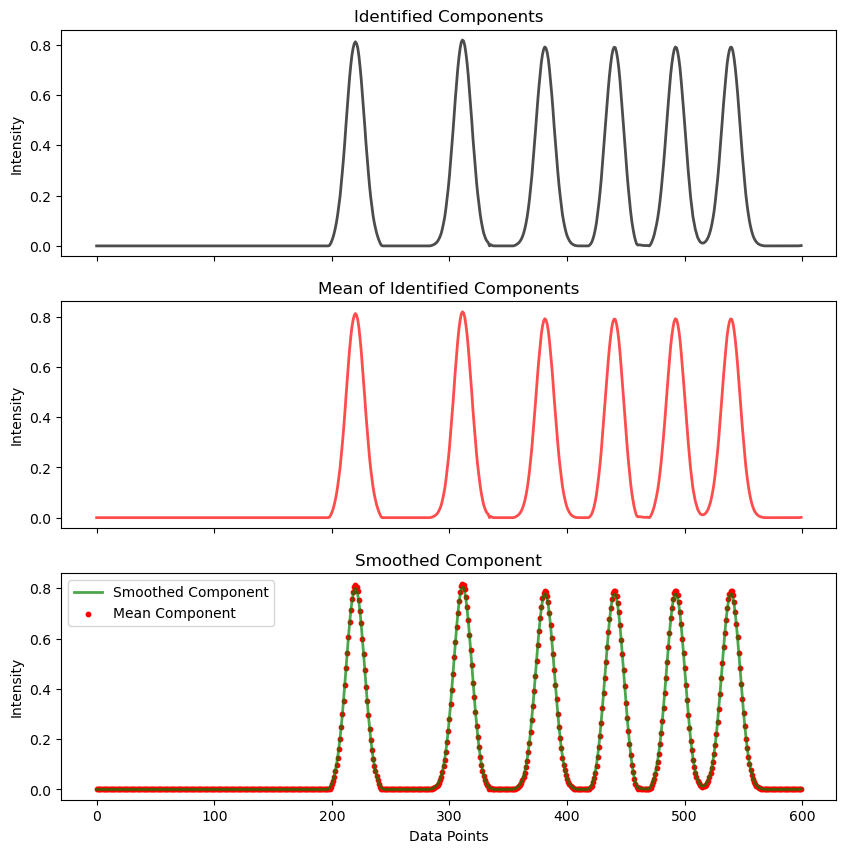

In [67]:
for_pdf_analysis = smooth_components(my_comps, 2, show = True)

In [70]:
import pyFAI
from pyFAI import AzimuthalIntegrator

Signature: AzimuthalIntegrator(*args, **kwargs)
Docstring: <no docstring>
Source:   
@decorators.deprecated(replacement="pyFAI.azimuthalIntegrator.AzimuthalIntegrator", since_version="0.16")
def AzimuthalIntegrator(*args, **kwargs):
    from .azimuthalIntegrator import AzimuthalIntegrator
    return AzimuthalIntegrator(*args, **kwargs)
File:      c:\users\dalverson\anaconda3\envs\dask_working\lib\site-packages\pyfai\__init__.py
Type:      function